In [1]:
using PyCall, Turing
import PyPlot; plt = PyPlot
;

In [2]:
pymunk, math, sys, random = pyimport.(["pymunk", "math", "sys", "random"])
;

In [10]:
function create_env(g, m, r, pos_0, vel_0)
    space = pymunk.Space()
    space.gravity = (0.0, g)
    mass = m
    radius = r
    inertia = pymunk.moment_for_circle(mass, 0, radius, (0,0))
    body = pymunk.Body(mass, inertia)
    body.position = pos_0[1], pos_0[2]
    body.velocity = vel_0[1], vel_0[2]
    shape = pymunk.Circle(body, radius, (0,0))
    space.add(body, shape)
    return space
end;

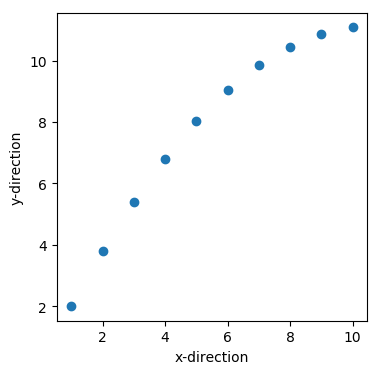

In [16]:
#Simulate observations
F = (0.0,-10.0)
space = create_env(-9.8, 1, 25, [0.0,0.0], [10.0, 20.0])
positions_x = []
positions_y = []

#Simulate for N time steps
time_steps = 10
positions = Array{Float64,2}(undef, 2, time_steps)
for i in 1:time_steps
    space.shapes[1].body.apply_force_at_world_point(force=F, point=(0,0))#(body.position[1],body.position[2]))
    space.step(1/10)
    append!(positions_x, get(space.shapes[1].body.position, 0))
    append!(positions_y, get(space.shapes[1].body.position, 1))
    positions[:,i] .= space.shapes[1].body.position
end
plt.figure(figsize=(4,4))
plt.scatter(positions_x, positions_y)
plt.xlabel("x-direction")
plt.ylabel("y-direction");

In [12]:
@model single_force(pos_list) = begin
    F ~ MvNormal(zeros(2), 10 * ones(2))
    # Define initial params of environment
    pos = [0.0, 0.0]
    vel = [10.0, 20.0]

    # Simulate environment
    for i in 1:size(pos_list, 2)
        # To mimic immutable object
        space = create_env(-9.8, 1, 25, pos, vel)
        # Apply force
        space.shapes[1].body.apply_force_at_world_point(force=tuple(F...), point=(0, 0))
        # Step simulation
        space.step(1 / 10)
        # Extract new state
        pos = [get(space.shapes[1].body.position, 0), get(space.shapes[1].body.position, 1)]
        vel = [get(space.shapes[1].body.velocity, 0), get(space.shapes[1].body.velocity, 1)]
        # Retrieve updated position
        pos_list[:,i] ~ MvNormal(pos, 1.0)
    end
end;

In [6]:
chain = sample(single_force(positions), PG(100), 500)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:02


Object of type Chains, with data of type 500×5×1 Array{Float64,3}

Log evidence      = -21.710773623275117
Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = le, lp, weight
parameters        = F[1], F[2]

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std     │ naive_se  │ mcse      │ ess     │
│     │ Symbol     │ Float64  │ Float64 │ Float64   │ Float64   │ Any     │
├─────┼────────────┼──────────┼─────────┼───────────┼───────────┼─────────┤
│ 1   │ F[1]       │ 0.064829 │ 1.21597 │ 0.05438   │ 0.118616  │ 75.4619 │
│ 2   │ F[2]       │ -9.8941  │ 1.50299 │ 0.0672158 │ 0.0810179 │ 48.8599 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%     │ 50.0%     │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64   │ Float64   │ Float64  │ Float64  │
├─────┼────────────┼──────────┼───────────┼───────────┼──────────┼──────────┤
│ 1   │ F[1]       │

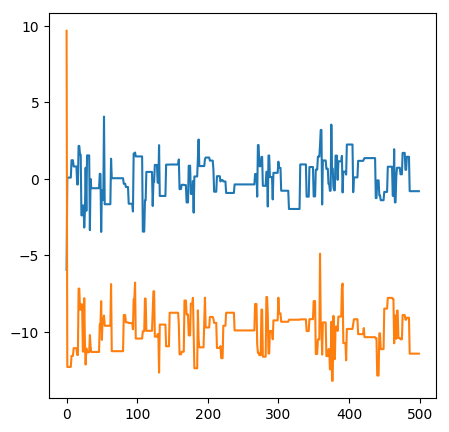

In [13]:
plt.figure(figsize=(5,5))
plt.plot(get(chain, :F).F[1])
plt.plot(get(chain, :F).F[2]);